__автоэнкодер__  

Евгений Борисов esborisov@sevsu.ru
 

сжимаем  картинку MNIST из размера [28x28] в [2]   
и восстанавливаем её обратно из [2] в [28x28]  

Reducing the Dimensionality of Data with Neural Networks  
G. E. Hinton and R. R. Salakhutdinov  
2006

http://www.cs.toronto.edu/~hinton/science.pdf



https://github.com/YunYang1994/TensorFlow2.0-Examples/blob/master/3-Neural_Network_Architecture/autoencoder.py


In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import tensorflow as tf
print('tensorflow', tf.__version__)
print('keras', tf.keras.__version__)

tensorflow 2.4.1
keras 2.4.0


## модель

In [3]:
# import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

!['Autoencoder'](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

In [4]:
# cжимаем вход 
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.dense_1 = tf.keras.layers.Dense(128, activation='tanh')
        self.dense_2 = tf.keras.layers.Dense(64 , activation='tanh')
        self.dense_3 = tf.keras.layers.Dense(32 , activation='tanh')
        self.dense_4 = tf.keras.layers.Dense(2  , activation='sigmoid')
    def call(self, x, training=False):
        out = self.dense_1(x)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return out

In [5]:
# восстанавливаем cжатый образ 
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense_1 = tf.keras.layers.Dense(16 , activation='tanh')
        self.dense_2 = tf.keras.layers.Dense(64 , activation='tanh')
        self.dense_3 = tf.keras.layers.Dense(128, activation='tanh')
        self.dense_4 = tf.keras.layers.Dense(784, activation='sigmoid')
    def call(self, x, training=False):
        out = self.dense_1(x)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return out

In [6]:
# собираем в одну модель
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def call(self, x, training=False):
        out = self.encoder(x, training)
        out = self.decoder(out, training)
        return out

## датасет

In [7]:
# загружаем датасет MNIST с изображениями цифр
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = (np.reshape(X_train, (-1, 784)) / 255.).astype(np.float32)
X_test = (np.reshape(X_test, (-1, 784)) / 255.).astype(np.float32)

In [8]:
# примеры для визуальной оценки результата
n_samples = 9
ii = np.random.randint(0,X_test.shape[0], n_samples)
sample = X_test[ii,:]

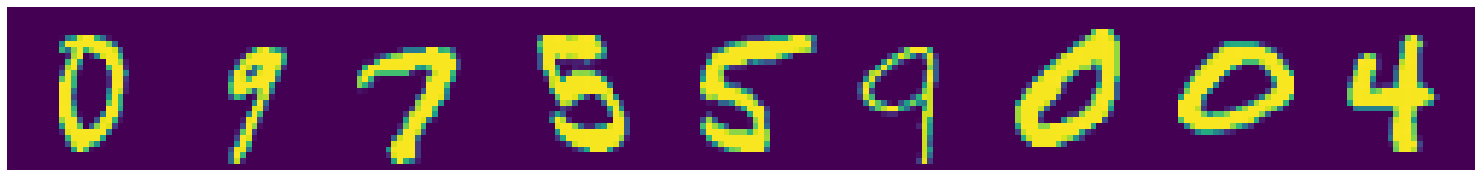

In [9]:
def plot_samples(image):
    ns = image.shape[0] 
    show_image = np.reshape(image, (ns, 28, 28)) 
    show_image = np.concatenate(show_image, -1)
    plt.figure(figsize=(ns*3,3))
    plt.axis(False)
    plt.imshow(show_image)

    #         plt.savefig('aenc/%05d.png'%(step))

plot_samples(sample)    


In [10]:
X_train.shape, sample.shape

((60000, 784), (9, 784))

## обучаем модель

In [11]:
model = Autoencoder()
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

=>    0 loss 0.2320
=> 1000 loss 0.0681
=> 2000 loss 0.0689
=> 3000 loss 0.0684
=> 4000 loss 0.0637
=> 5000 loss 0.0565
=> 6000 loss 0.0540
=> 7000 loss 0.0518
=> 8000 loss 0.0512
=> 9000 loss 0.0472
=> 10000 loss 0.0458
=> 11000 loss 0.0443
=> 12000 loss 0.0431
=> 13000 loss 0.0423
=> 14000 loss 0.0417
CPU times: user 1min 58s, sys: 1.05 s, total: 1min 59s
Wall time: 2min 2s


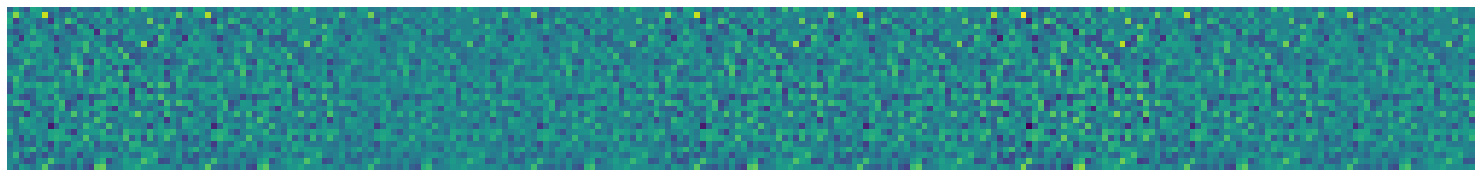

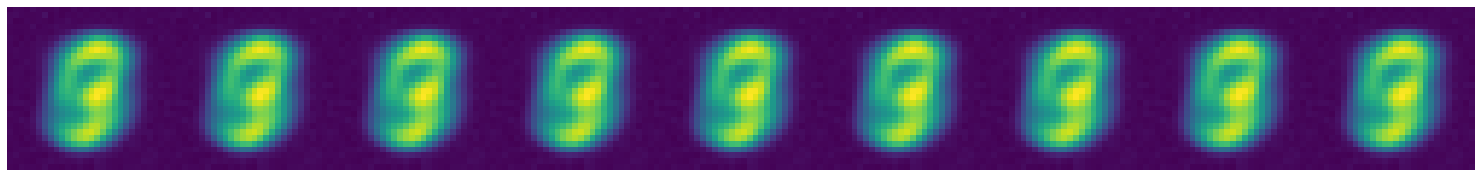

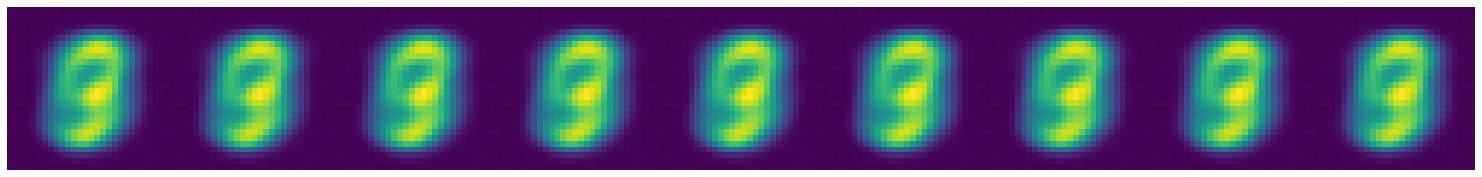

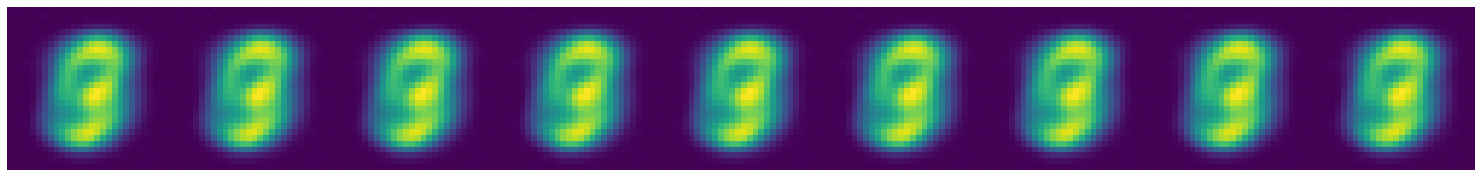

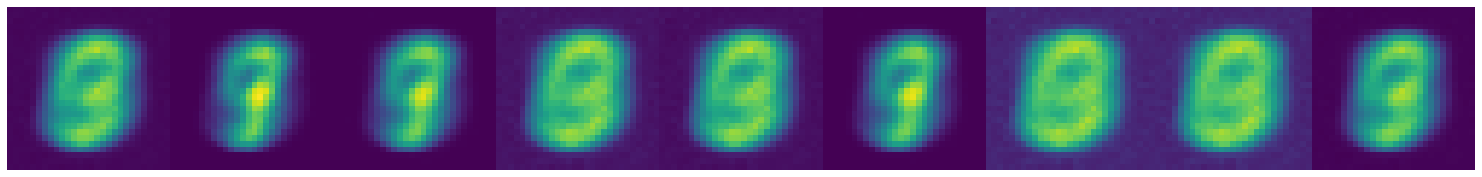

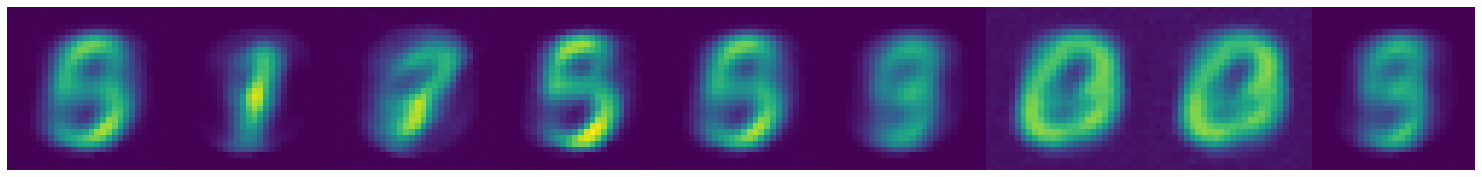

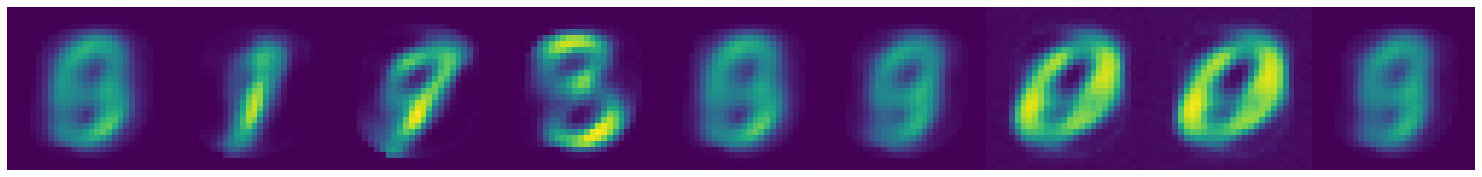

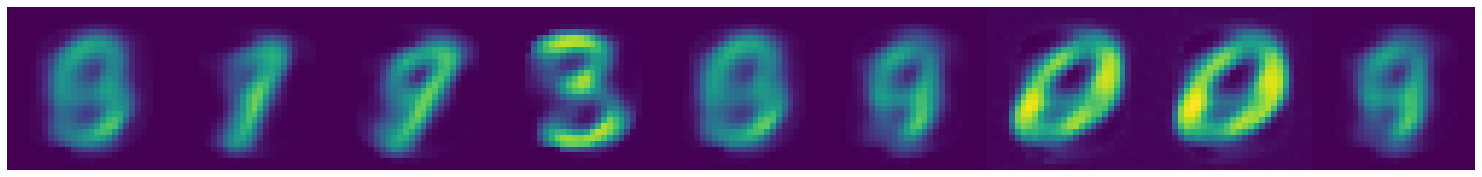

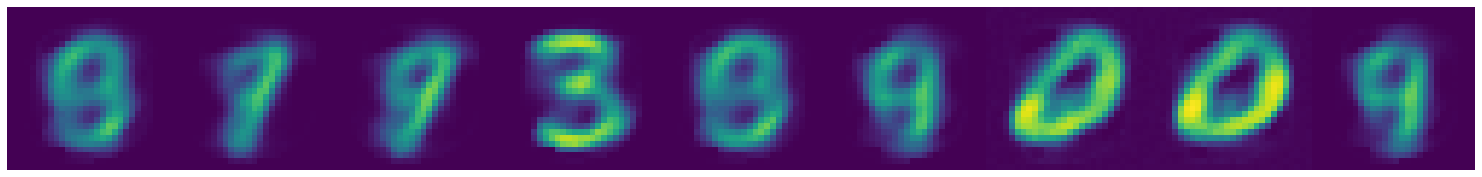

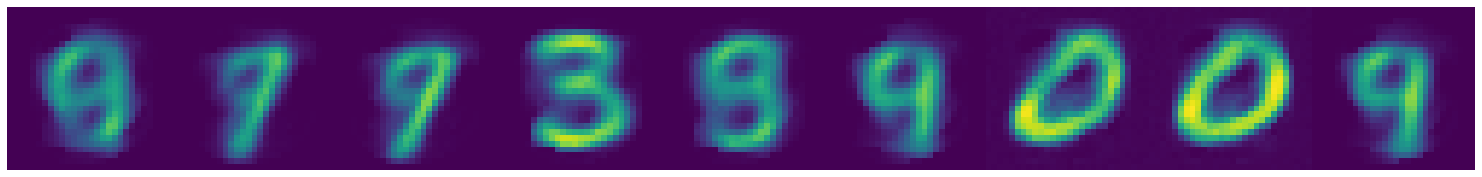

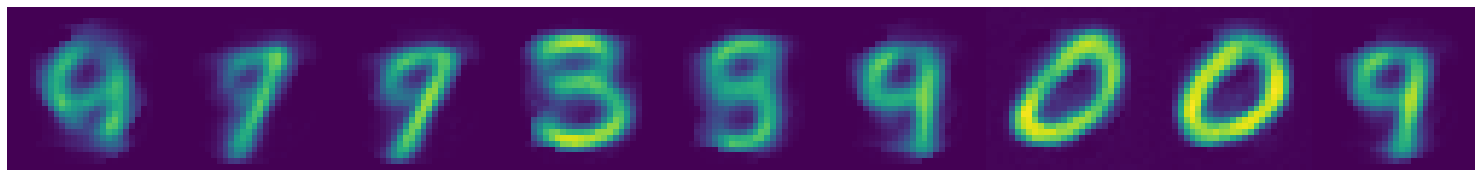

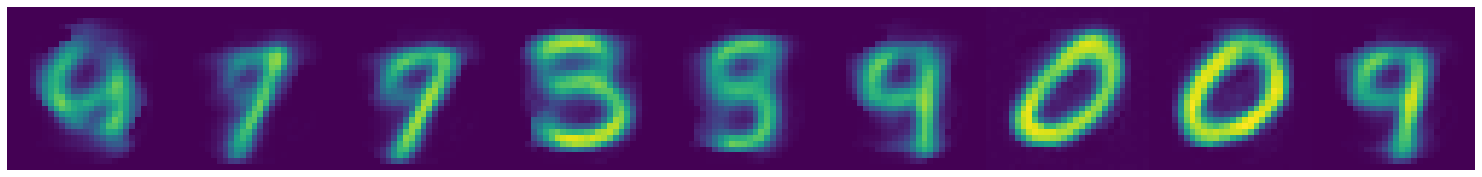

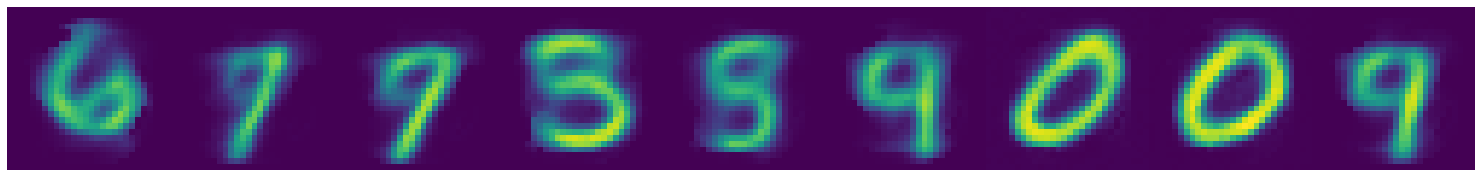

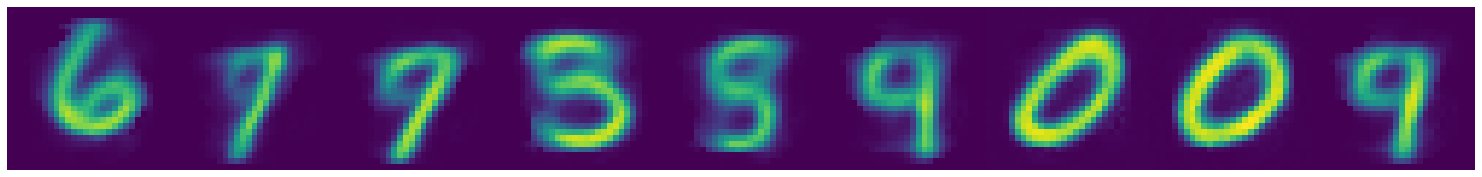

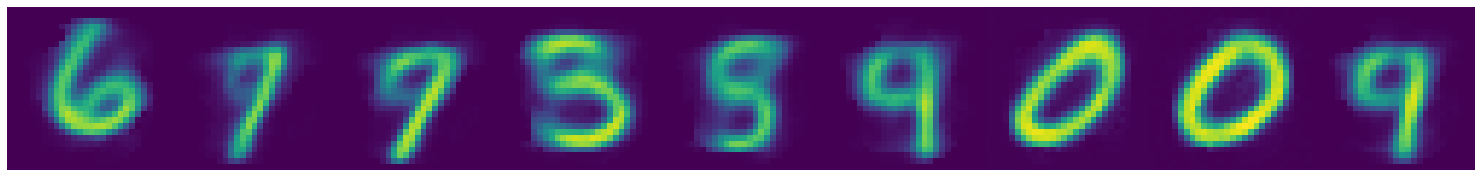

In [12]:
%%time 

n_epoch = 15000
batch_size = 512
loss_history = []


def train_step(x,optimizer=optimizer):
    with tf.GradientTape() as tape:
        p = model(x, training=True) # прямой проход
        loss = tf.reduce_mean(tf.square(p - x)) # расчёт потери
        gradients = tape.gradient(loss, model.trainable_variables) # расчёт градиета
        optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # коррекция параметров
    return loss   


for step in range(n_epoch):
    x_batch = X_train[np.random.choice(X_train.shape[0], batch_size)]
    loss = train_step(x_batch).numpy()
    loss_history.append(loss)
    
    if step % 1000 == 0:
        print("=> %4d loss %.4f" %(step, loss))
        plot_samples( model(sample, training=False) )

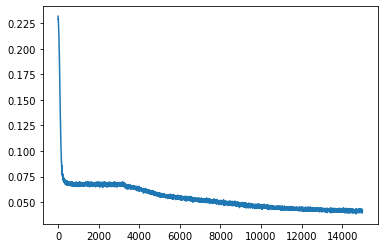

In [13]:
plt.plot(loss_history)

## тестируем

In [20]:
# примеры для визуальной оценки результата
n_samples = 9
ii = np.random.randint(0,X_test.shape[0], n_samples)
sample = X_test[ii,:]

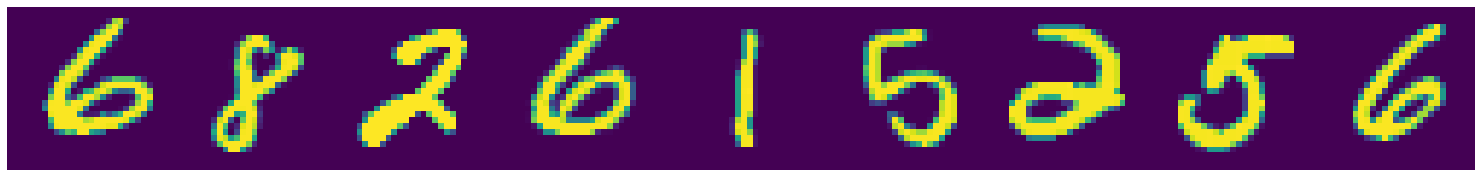

In [21]:
# оригинальные образы
plot_samples(sample)

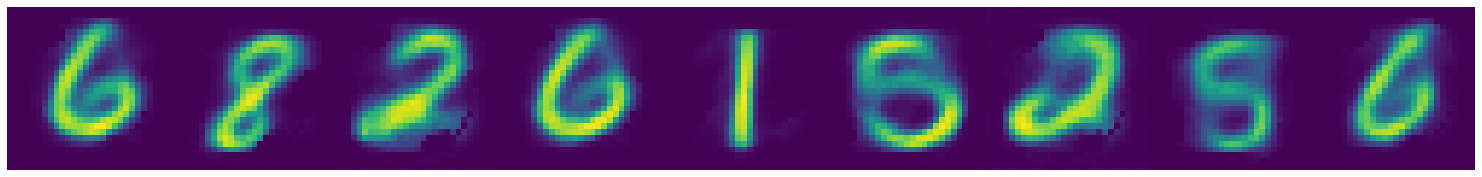

In [22]:
# восстановленные образы
plot_samples( model(sample, training=False) ) 

---

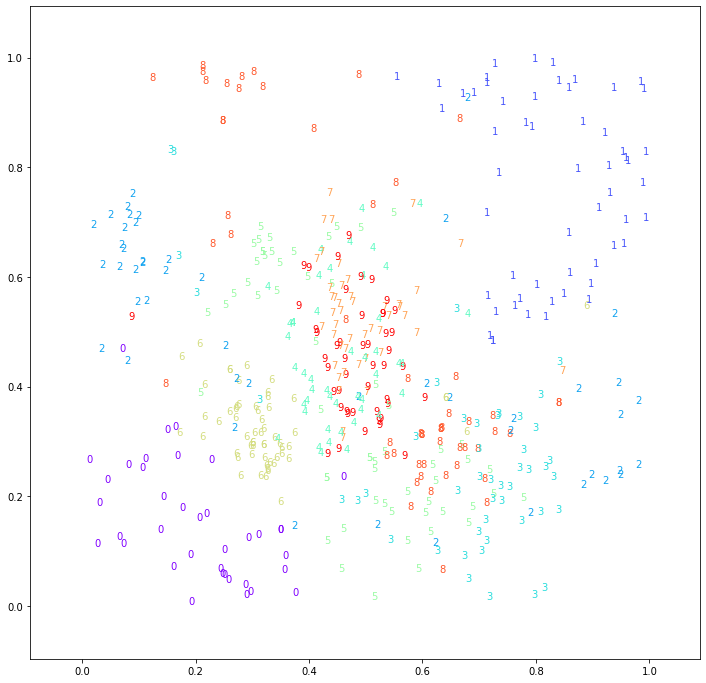

In [19]:
# рисуем эмбединги,
# т.е. состояние выхода энкодера (размерности 2) и метку входного образа

ii = np.random.randint(0,X_test.shape[0], 500)

embeddings = model.encoder(X_test[ii,:], training=False).numpy()
X,Y,label = embeddings[:,0],embeddings[:,1], y_test[ii]
colors = { i:cm.rainbow(int((255*i)/9)) for i in range(10) }

fig,ax = plt.subplots(figsize=(12,12))
for x,y,l in zip(X,Y,label): ax.text(x, y, l, color=colors[l])
ax.axis(True)
ax.set_xlim([X.min()-.1,X.max()+.1])
ax.set_ylim([Y.min()-.1,Y.max()+.1])

plt.show()